In [ ]:
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install gensim
!pip install nltk

In [ ]:
!pip install gensim
!pip install nltk

In [ ]:
import pandas as pd

df_latin = pd.read_csv('https://github.com/yarathealmighty/dumps/blob/main/parsed/latin.csv?raw=true')
df_engineer = pd.read_csv('https://github.com/yarathealmighty/dumps/blob/main/parsed/engineer.csv?raw=true')

In [ ]:
def answer_conc(df):

  df_questions = df[df['ParentId'].isna()]
  df_answers = df[df['ParentId'].notna()]

  df_answers = df_answers.drop(columns=['AcceptedAnswerId','ViewCount','Tags'])

  df_questions = df_questions.merge(df_answers[['Id','Text']], how='left', left_on='AcceptedAnswerId', right_on='Id', suffixes=('', '_Answer'))
  df_questions.rename(columns={'Text_Answer': 'Answer'}, inplace=True)
  df_questions = df_questions.drop(columns='Id_Answer')
  df_answers_reduced = df_answers.loc[df_answers.groupby('ParentId')['Score'].idxmax()]
  df_no_accepted_answer = df_questions[df_questions['AcceptedAnswerId'].isna()]

  for index, row in df_no_accepted_answer.iterrows():
    question_id = row['Id']
    highest_scored_answer = df_answers_reduced[df_answers_reduced['ParentId'] == question_id]
    if not highest_scored_answer.empty:
        df_questions.at[index, 'Answer'] = highest_scored_answer.iloc[0]['Text']
  return df_questions

In [ ]:
def process_tags(tags):
    if pd.isna(tags):
      return []
    tags_list = tags.split('|')
    return tags_list[1:-1] if len(tags_list) > 2 else []

In [ ]:
def big_clean(df):
  df = df.drop(columns=['LastActivityDate','CreationDate','PostTypeId','OwnerUserId','ContentLicense','CommentCount','AnswerCount'])
  df['Text'] = df['Title'].fillna('') + ' ' + df['Body'].fillna('').str.strip()
  df = df.drop(columns=['Body','Title'])

  questions = answer_conc(df)

  questions.rename(columns={'Text':'Question'},inplace=True)
  questions = questions.drop(columns=['ViewCount','AcceptedAnswerId','ParentId','Score'])

  questions['Tags'] = questions['Tags'].apply(process_tags)

  return questions

In [ ]:
latin = big_clean(df_latin)
# ~1000 questions dropped
# latin = latin.dropna(subset=['Answer'])
latin

,Id,Tags,Question,Answer
0,1,"[classical-latin, meaning, vocabulary, conjunc...","Are ""-que"" and ""et"" equivalent? I was taught t...","The way I was taught was that, as a general r..."
1,2,"[contemporary-latin, pronouns, articles, trans...","Why is ""ille"" used in Winnie ille Pu and Hobbi...","It's true that in Classical Latin, ille is a ..."
2,4,"[agreement, predicate, gender, adjective, clas...",What gender should a predicate adjective be to...,Bennett's New Latin Grammar ( this link will ...
3,5,[pronunciation],What effect should a macron have on the sound ...,"In most modern texts, the whole purpose of us..."
4,7,"[etymology, particle, hebrew]","Does ""ad"" have its origin in Hebrew/Semitic la...","No, the similarity is almost certainly accide..."
...,...,...,...,...
6834,23420,[english-to-latin-translation],Four more loaves please This new question: How...,"In Nicholas Oulton's Book II, p.50: ""plures c..."
6835,23425,"[latin-to-english-translation, mathematics]","Mathematical Latin Help So, I'm a PhD student ...","I understand ""ut quotiens sit integer complex..."
6836,23429,"[latin-to-english-translation, translation-check]",Does “interranima” mean “inner soul”? I came a...,"No. Anima is the Latin word for soul, apart f..."
6837,23432,"[diphthong, paleography, ligatures]",What diphthongs are available are Unicode liga...,NaN


In [ ]:
engineer = big_clean(df_engineer)
# ~2000 questions dropped
# engineer = engineer.dropna(subset=['Answer'])
engineer

,Id,Tags,Question,Answer
0,1,"[ipsec, ike, vpn]",What's the difference between IKE and ISAKMP? ...,"ISAKMP is part of IKE. (IKE has ISAKMP, SKEME..."
1,3,[qos],Quality of Service based on Layer 7 traffic Ho...,I think this depends heavily on the platform ...
2,4,"[cisco-catalyst, bgp]","Troubleshooting ""Down BGP"" connections Our net...",172259: May 6 14:43:06: %BGP-3-NOTIFICATION:...
3,5,"[ospf, security]",Securing OSPF with only passive interfaces I k...,One issue is that authentication ensures that...
4,6,"[juniper, policing, juniper-ex]",Aggregate Family Rate Limits on Juniper EX Try...,"You are looking for the ""Logical Interface (A..."
...,...,...,...,...
17516,85395,"[switch, network, networking]",Can I configure my Linux box as a virtual netw...,NaN
17517,85396,[tcp],"How does a server handle multiple requests, an...",NaN
17518,85398,"[switch, network, networking, layer3]",Core Switches Redundancy Problem I have networ...,"There are several ways to do this, depending ..."
17519,85401,"[juniper, ipv6, dhcp, dhcpv6, dhcp-snooping]",Juniper and EdgeCore dhcpv6-relay remote-id (o...,NaN


In [ ]:
#BOW unigram, tisztitást még megnézek rá hátha
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(engineer['Question'])
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())
df_bow_sklearn.head()

,00,000,0000,00000,000000,0000000,00000000,000000000,0000000000,00000000000,...,接口列表,活动路由,的路由,网关,网络掩码,网络目标,请求超时,跃点数,路由表,通过最多
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import numpy as np
import nltk
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

def calculate_average_cosine_similarity(model, documents):
    document_similarities = []

    for document in documents:
        words = word_tokenize(document.lower())
        vectors = [model.wv[word] for word in words if word in model.wv]

        if len(vectors) < 2:
            document_similarities.append(0.0)
            continue

        cosine_sim_matrix = cosine_similarity(vectors)
        upper_tri_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
        similarities = cosine_sim_matrix[upper_tri_indices]

        average_similarity = np.mean(similarities)
        document_similarities.append(average_similarity)

    return document_similarities

def w2v_vectorize(df):
  corpus_text = ' '.join(latin['Question'])
  data = []
  for sentence in sent_tokenize(corpus_text):
      temp = []
      for word in word_tokenize(sentence):
        temp.append(word.lower())
      data.append(temp)

  cbow = gensim.models.Word2Vec(data, min_count=1, vector_size=100, window=5, sg=0)
  skipgram = gensim.models.Word2Vec(data, min_count=1, vector_size=100, window=5, sg=1)
  return (cbow,skipgram)

In [ ]:
cbow, skipgram = w2v_vectorize(latin)

latin['Cosine Similarity (CBOW)'] = calculate_average_cosine_similarity(cbow, latin['Question'])
latin['Cosine Similarity (Skip-gram)'] = calculate_average_cosine_similarity(skipgram, latin['Question'])

cbow, skipgram = w2v_vectorize(engineer)

engineer['Cosine Similarity (CBOW)'] = calculate_average_cosine_similarity(cbow, engineer['Question'])
engineer['Cosine Similarity (Skip-gram)'] = calculate_average_cosine_similarity(skipgram, engineer['Question'])

In [ ]:
latin.to_csv('latin_cosine',index=False)
engineer.to_csv('engineer_cosine',index=False)

In [ ]:
engineer

,Id,Tags,Question,Answer,Cosine Similarity (CBOW),Cosine Similarity (Skip-gram)
0,1,"[ipsec, ike, vpn]",What's the difference between IKE and ISAKMP? ...,"ISAKMP is part of IKE. (IKE has ISAKMP, SKEME...",0.409774,0.585711
1,3,[qos],Quality of Service based on Layer 7 traffic Ho...,I think this depends heavily on the platform ...,0.403953,0.632087
2,4,"[cisco-catalyst, bgp]","Troubleshooting ""Down BGP"" connections Our net...",172259: May 6 14:43:06: %BGP-3-NOTIFICATION:...,0.421891,0.588198
3,5,"[ospf, security]",Securing OSPF with only passive interfaces I k...,One issue is that authentication ensures that...,0.427049,0.577127
4,6,"[juniper, policing, juniper-ex]",Aggregate Family Rate Limits on Juniper EX Try...,"You are looking for the ""Logical Interface (A...",0.427832,0.606404
...,...,...,...,...,...,...
17516,85395,"[switch, network, networking]",Can I configure my Linux box as a virtual netw...,NaN,0.409406,0.592866
17517,85396,[tcp],"How does a server handle multiple requests, an...",NaN,0.430076,0.622251
17518,85398,"[switch, network, networking, layer3]",Core Switches Redundancy Problem I have networ...,"There are several ways to do this, depending ...",0.354970,0.595247
17519,85401,"[juniper, ipv6, dhcp, dhcpv6, dhcp-snooping]",Juniper and EdgeCore dhcpv6-relay remote-id (o...,NaN,0.386228,0.541851


In [11]:
df = pd.read_csv('https://github.com/yarathealmighty/dumps/blob/main/cosine/latin_cosine.csv?raw=true')
df = df[df['Answer'].notna()]
df

,Id,Tags,Question,Answer,Cosine Similarity (CBOW),Cosine Similarity (Skip-gram)
0,1,"['classical-latin', 'meaning', 'vocabulary', '...","Are ""-que"" and ""et"" equivalent? I was taught t...","The way I was taught was that, as a general r...",0.376483,0.533986
1,2,"['contemporary-latin', 'pronouns', 'articles',...","Why is ""ille"" used in Winnie ille Pu and Hobbi...","It's true that in Classical Latin, ille is a ...",0.336087,0.566115
2,4,"['agreement', 'predicate', 'gender', 'adjectiv...",What gender should a predicate adjective be to...,Bennett's New Latin Grammar ( this link will ...,0.387429,0.567729
3,5,['pronunciation'],What effect should a macron have on the sound ...,"In most modern texts, the whole purpose of us...",0.472779,0.607277
4,7,"['etymology', 'particle', 'hebrew']","Does ""ad"" have its origin in Hebrew/Semitic la...","No, the similarity is almost certainly accide...",0.368243,0.542787
...,...,...,...,...,...,...
6833,23416,"['english-to-latin-translation', 'classical-la...","Can someone help translating ""one must die for...",One possibility: necesse est alterum mori ut ...,0.414603,0.562434
6834,23420,['english-to-latin-translation'],Four more loaves please This new question: How...,"In Nicholas Oulton's Book II, p.50: ""plures c...",0.352794,0.520526
6835,23425,"['latin-to-english-translation', 'mathematics']","Mathematical Latin Help So, I'm a PhD student ...","I understand ""ut quotiens sit integer complex...",0.394950,0.557162
6836,23429,"['latin-to-english-translation', 'translation-...",Does “interranima” mean “inner soul”? I came a...,"No. Anima is the Latin word for soul, apart f...",0.334330,0.523648


In [ ]:
import nltk
!python -m nltk.downloader all

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/

In [ ]:
# manual cleaning
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

questions = df['Question']
text = ''.join(questions[:500])

tokens = word_tokenize(text)
tokens = [w.lower() for w in tokens]
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
stripped = [re_punc.sub('', w) for w in tokens]
words = [word for word in stripped if word.isalpha()]
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]
print(words)

# lemma vs stem kérdés itt felmerül

['que', 'et', 'equivalent', 'taught', 'one', 'use', 'que', 'suffix', 'string', 'together', 'multiple', 'words', 'similar', 'way', 'putting', 'et', 'two', 'equivalent', 'one', 'connotation', 'classical', 'caesarera', 'latin', 'nt', 'ille', 'used', 'winnie', 'ille', 'pu', 'hobbitus', 'ille', 'learned', 'early', 'latin', 'articles', 'winnie', 'pooh', 'hobbit', 'translated', 'winnie', 'ille', 'pu', 'hobbitus', 'ille', 'would', 'nt', 'correct', 'translate', 'article', 'justification', 'including', 'ille', 'book', 'titles', 'gender', 'predicate', 'adjective', 'agree', 'series', 'things', 'different', 'genders', 'like', 'translate', 'following', 'sentence', 'latin', 'pompeii', 'rome', 'herculaneum', 'visited', 'boys', 'however', 'since', 'three', 'cities', 'different', 'genders', 'struggling', 'choose', 'right', 'ending', 'put', 'blank', 'pompeii', 'et', 'herculaneum', 'et', 'roma', 'visitat', 'sunt', 'pueris', 'know', 'could', 'recast', 'sentence', 'avoid', 'problem', 'convention', 'classica

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:01<00:00, 14587855.11it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 315941.09it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5768996.21it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15291980.87it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
      for X, y in dataloader:
          X, y = X.to(device), y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return (correct,test_loss)

Using cpu device


In [5]:
accuracies = []
avg_losses = []

In [8]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    accuracy, avg_loss = test(test_dataloader, model, loss_fn)
    accuracies.append(accuracy)
    avg_losses.append(avg_loss)
print("Done!")
data = {'Accuracy' : accuracies, 'Average loss' : avg_losses}
df = pd.DataFrame(data)

Epoch 1
-------------------------------
loss: 0.540066  [   64/60000]
loss: 0.661096  [ 6464/60000]
loss: 0.445051  [12864/60000]
loss: 0.696609  [19264/60000]
loss: 0.615306  [25664/60000]
loss: 0.592201  [32064/60000]
loss: 0.640053  [38464/60000]
loss: 0.681700  [44864/60000]
loss: 0.664315  [51264/60000]
loss: 0.618468  [57664/60000]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.610538 

Epoch 2
-------------------------------
loss: 0.526711  [   64/60000]
loss: 0.647811  [ 6464/60000]
loss: 0.435068  [12864/60000]
loss: 0.687010  [19264/60000]
loss: 0.607307  [25664/60000]
loss: 0.585444  [32064/60000]
loss: 0.627376  [38464/60000]
loss: 0.676815  [44864/60000]
loss: 0.658668  [51264/60000]
loss: 0.608127  [57664/60000]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.601150 

Epoch 3
-------------------------------
loss: 0.514474  [   64/60000]
loss: 0.635619  [ 6464/60000]
loss: 0.425871  [12864/60000]
loss: 0.677981  [19264/60000]
loss: 0.599721  [25664/60000]
loss: 0.579279  [32064/600

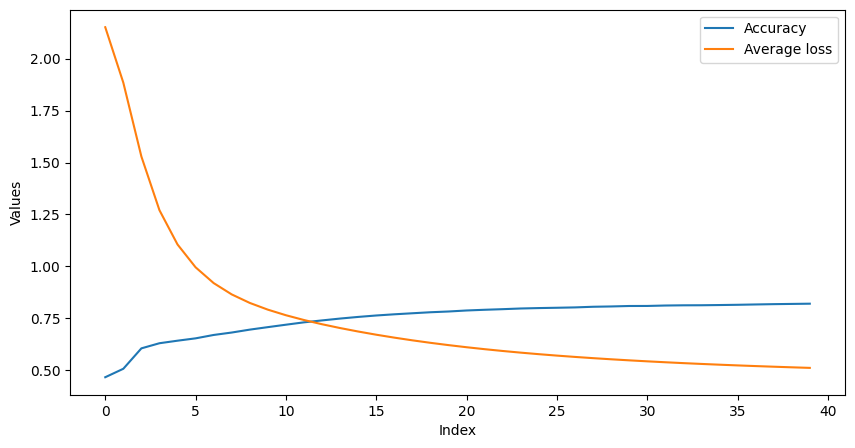

Saved PyTorch Model State to playtest.pth


In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['Accuracy'], label='Accuracy')
plt.plot(df['Average loss'], label='Average loss')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

torch.save(model.state_dict(), "playtest.pth")
print("Saved PyTorch Model State to playtest.pth")

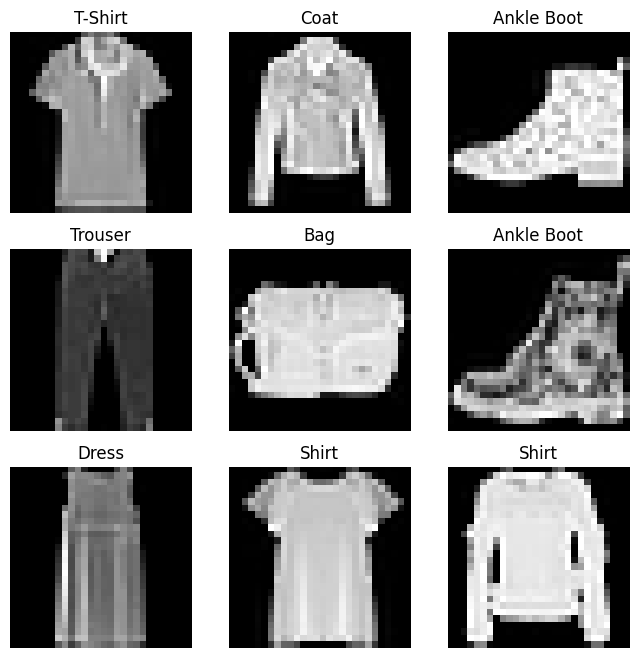

In [10]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [42]:
df = pd.read_csv('https://github.com/yarathealmighty/dumps/blob/main/data/not_na_tags/latin_not_na_tags.csv?raw=true')
df = df[df['Tags'].map(len) > 0]
df.to_csv('latin_not_na_tags.csv',index=False)

In [73]:
df['Tags']

0       ['classical-latin', 'meaning', 'vocabulary', '...
1       ['contemporary-latin', 'pronouns', 'articles',...
2       ['agreement', 'predicate', 'gender', 'adjectiv...
3                                       ['pronunciation']
4                     ['etymology', 'particle', 'hebrew']
                              ...                        
5879    ['english-to-latin-translation', 'classical-la...
5880                     ['english-to-latin-translation']
5881      ['latin-to-english-translation', 'mathematics']
5882    ['latin-to-english-translation', 'translation-...
5883    ['pronunciation', 'spelling', 'diphthong', 'li...
Name: Tags, Length: 5884, dtype: object

In [82]:
def get_unique_tags(df):
  tags_list = df['Tags']
  unique_tags = set([])
  for tags in tags_list:
    tags = tags.split("'")[1:-1:2]
    for tag in tags:
      unique_tags.add(tag)
  return list(unique_tags)

In [105]:
from sklearn.preprocessing import LabelEncoder

latin_ut = get_unique_tags(df)
#374-es output layer

label_encoder = LabelEncoder()
label_encoder.fit(latin_ut)

# Create a mapping of tags to their encoded labels
tag_to_label = dict(zip(latin_ut, label_encoder.transform(latin_ut)))

labels = list(tag_to_label.values())
labels

[349,
 232,
 287,
 12,
 347,
 92,
 209,
 181,
 105,
 163,
 113,
 87,
 166,
 284,
 242,
 303,
 45,
 144,
 82,
 171,
 15,
 30,
 168,
 272,
 197,
 189,
 351,
 211,
 98,
 245,
 25,
 62,
 307,
 221,
 155,
 169,
 252,
 297,
 231,
 131,
 302,
 42,
 255,
 359,
 200,
 63,
 6,
 194,
 262,
 329,
 151,
 246,
 49,
 340,
 182,
 280,
 179,
 268,
 362,
 327,
 159,
 124,
 180,
 282,
 3,
 47,
 20,
 353,
 356,
 161,
 286,
 150,
 164,
 188,
 91,
 4,
 331,
 363,
 230,
 40,
 5,
 210,
 158,
 55,
 276,
 2,
 115,
 365,
 89,
 292,
 37,
 10,
 31,
 228,
 251,
 139,
 279,
 336,
 345,
 196,
 263,
 103,
 337,
 314,
 256,
 216,
 80,
 17,
 296,
 186,
 304,
 36,
 81,
 57,
 177,
 324,
 14,
 241,
 217,
 312,
 352,
 249,
 344,
 64,
 360,
 269,
 213,
 157,
 114,
 83,
 224,
 70,
 320,
 156,
 218,
 143,
 198,
 33,
 343,
 355,
 106,
 111,
 281,
 243,
 318,
 295,
 116,
 109,
 148,
 120,
 290,
 270,
 191,
 19,
 236,
 306,
 226,
 68,
 90,
 285,
 95,
 301,
 334,
 250,
 117,
 294,
 299,
 207,
 283,
 335,
 364,
 162,
 348,
 21,
 53

In [91]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np

tokenized_questions = [simple_preprocess(q) for q in df['Question']]

model = Word2Vec(sentences=tokenized_questions, vector_size=50, window=5, min_count=1, workers=4)

# Create a function to get the vector for a question
def get_vector(question, model):
    tokens = simple_preprocess(question)
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Apply the function to get vectors for each question
df['Question_Vector'] = df['Question'].apply(lambda x: get_vector(x, model))

print("Word Embeddings:")
df

Word Embeddings:


,Id,Tags,Question,Answer,Cosine Similarity (CBOW),Cosine Similarity (Skip-gram),Question_Vector
0,1,"['classical-latin', 'meaning', 'vocabulary', '...","Are ""-que"" and ""et"" equivalent? I was taught t...","The way I was taught was that, as a general r...",0.376483,0.533986,"[-0.56718177, -0.08636381, 0.054728687, 0.1385..."
1,2,"['contemporary-latin', 'pronouns', 'articles',...","Why is ""ille"" used in Winnie ille Pu and Hobbi...","It's true that in Classical Latin, ille is a ...",0.336087,0.566115,"[-0.59893906, -0.18989469, 0.17554568, 0.22921..."
2,4,"['agreement', 'predicate', 'gender', 'adjectiv...",What gender should a predicate adjective be to...,Bennett's New Latin Grammar ( this link will ...,0.387429,0.567729,"[-0.6498057, -0.15954323, 0.10755014, 0.170051..."
3,5,['pronunciation'],What effect should a macron have on the sound ...,"In most modern texts, the whole purpose of us...",0.472779,0.607277,"[-0.5373992, -0.14705694, 0.39335102, 0.563400..."
4,7,"['etymology', 'particle', 'hebrew']","Does ""ad"" have its origin in Hebrew/Semitic la...","No, the similarity is almost certainly accide...",0.368243,0.542787,"[-0.61840487, -0.082715265, 0.04258449, 0.2878..."
...,...,...,...,...,...,...,...
5879,23416,"['english-to-latin-translation', 'classical-la...","Can someone help translating ""one must die for...",One possibility: necesse est alterum mori ut ...,0.414603,0.562434,"[-1.1481794, -0.19188693, -0.02219345, 0.12933..."
5880,23420,['english-to-latin-translation'],Four more loaves please This new question: How...,"In Nicholas Oulton's Book II, p.50: ""plures c...",0.352794,0.520526,"[-0.72917694, -0.37934136, 0.17634495, 0.17181..."
5881,23425,"['latin-to-english-translation', 'mathematics']","Mathematical Latin Help So, I'm a PhD student ...","I understand ""ut quotiens sit integer complex...",0.394950,0.557162,"[-0.5885769, -0.21838634, 0.14769343, 0.280921..."
5882,23429,"['latin-to-english-translation', 'translation-...",Does “interranima” mean “inner soul”? I came a...,"No. Anima is the Latin word for soul, apart f...",0.334330,0.523648,"[-1.1123039, -0.08139609, -0.25557762, 0.14454..."


In [98]:
import io

question_vectors = np.stack(df['Question_Vector'].values)
question_vectors_tensor = torch.tensor(question_vectors, dtype=torch.float32)

print("Word2Vec Tensor:")
print(question_vectors_tensor)

torch.save(question_vectors_tensor, 'latin_questions.pt')
# Save to io.BytesIO buffer
buffer = io.BytesIO()
torch.save(question_vectors_tensor, buffer)

Word2Vec Tensor:
tensor([[-0.5672, -0.0864,  0.0547,  ..., -0.7071,  1.0195,  1.7980],
        [-0.5989, -0.1899,  0.1755,  ..., -0.3535,  0.7964,  1.3310],
        [-0.6498, -0.1595,  0.1076,  ..., -0.3990,  0.8202,  1.4801],
        ...,
        [-0.5886, -0.2184,  0.1477,  ..., -0.3153,  0.6832,  1.2141],
        [-1.1123, -0.0814, -0.2556,  ..., -0.2766,  1.0107,  1.3276],
        [-0.5569, -0.1634,  0.0893,  ..., -0.5804,  0.8951,  1.6884]])


In [ ]:
#vektor után plot
#könyv + pytorch

#mini-project: neur.háló ami tag(ek)et ad kérdéseknek
  # tagek csoportjából ha olyat választ ami ténylegesen jó, akkor 1 amúgy 0

  # steps: tagek összegyűjtése (ennyi output fog kelleni), questionök előkészitése + vektorizálása, vektorok tenzorokká alakitása, neur. háló tanitás + finomhangolás, kiértékelés + javitás